In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5

## you can undo the lines below (but it will be fun for making fancy plots!)
# to make the lines below work, you have to download the file 'PostProcessingScripts' from https://github.com/FloorBroekgaarden/common_code
# and put this in the same directory as this one, and then only use the bottom line from this code below 


# from PostProcessingScripts import * 

# to make the screen wider
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


import tables

# print("PyTables version:", tables.__version__)
# print("HDF5 version:", tables.get_hdf5_version())

In [2]:
# For you the part '/Volumes/Andromeda/DATA/AllDCO_bugfix/fiducial/' is probably different

path = '/Volumes/GROWL/Boesky24/alpha0_1beta0_25/'
file_name = 'COMPAS_Output_Weighted.h5'

full_path = path + file_name
fdata = h5.File(full_path, 'r')

print(fdata['BSE_System_Parameters'].keys())


<KeysViewHDF5 ['Add_Options_To_SysParms', 'Allow_Immediate_RLOF>CE_To_Survive_CE', 'Allow_MS_To_Survive_CE', 'Allow_Non_Stripped_ECSN', 'Allow_RLOF@Birth', 'Allow_Radiative_Envelope_To_Survive_CE', 'Allow_Touching@Birth', 'BB_Mass_xFer_Stblty_Prscrptn', 'BH_Kicks', 'CE_Alpha', 'CE_Alpha_Thermal', 'CE_Lambda', 'CE_Lambda_Multiplier', 'CE_Lambda_Prscrptn', 'CE_Mass_Accr_Constant', 'CE_Mass_Accr_Max', 'CE_Mass_Accr_Min', 'CE_Mass_Accr_Prscrptn', 'CE_Recomb_Enrgy_Dnsty', 'CE_Slope_Kruckow', 'CHE_Mode', 'CH_on_MS(1)', 'CH_on_MS(2)', 'Check_Photon_Tiring_Limit', 'Circularise@MT', 'Conserve_AngMom@Circ', 'Cool_WindMassLoss_Multipl', 'Eccentricity', 'Eccentricity@ZAMS', 'Eccentricity_Dstrbtn', 'Eccentricity_Dstrbtn_Max', 'Eccentricity_Dstrbtn_Min', 'Eddington_Accr_Factor', 'Envelope_State_Prscrptn', 'Equilibrated_At_Birth', 'Error', 'Evolution_Mode', 'Fryer22_crit_COcore_Mass', 'Fryer22_mixing_fraction', 'Fryer_SN_Engine', 'Initial_Mass', 'Initial_Mass(1)', 'Initial_Mass(2)', 'Initial_Mass_Fun

In [3]:
print(fdata['Run_Details']['metallicity-min'][()][0])
metallicity_min = fdata['Run_Details']['metallicity-min'][()][0]


for param in ['semi-major-axis-max', 'semi-major-axis-min', 'minimum-secondary-mass', 'mass-ratio-min', 'mass-ratio-max',  'initial-mass-max', 'initial-mass-min']:
    param_val = fdata['Run_Details'][param][()][0]
    print(param, ' = ', param_val)
    


0.0001
semi-major-axis-max  =  1000.0
semi-major-axis-min  =  0.01
minimum-secondary-mass  =  0.1
mass-ratio-min  =  0.01
mass-ratio-max  =  1.0
initial-mass-max  =  150.0
initial-mass-min  =  5.0


### Calculate the formation efficiency 

In [4]:
# This function below is copied from GROWL-catalog-public/CosmicIntegration/cosmic_integration/totalMassEvolvedPerZ.py

def analytical_star_forming_mass_per_binary_using_kroupa_imf(
        m1_min, m1_max, m2_min, fbin=1., imf_mass_bounds=[0.01,0.08,0.5,200]
):
    """
    Analytical computation of the mass of stars formed per binary star formed within the
    [m1 min, m1 max] and [m2 min, ..] rage,
    using the Kroupa IMF:

        p(M) \propto M^-0.3 for M between m1 and m2
        p(M) \propto M^-1.3 for M between m2 and m3;
        p(M) = alpha * M^-2.3 for M between m3 and m4;

    @Ilya Mandel's derivation
    """
    m1, m2, m3, m4 = imf_mass_bounds
    if m1_min < m3:
        raise ValueError(f"This analytical derivation requires IMF break m3  < m1_min ({m3} !< {m1_min})")
    alpha = (-(m4**(-1.3)-m3**(-1.3))/1.3 - (m3**(-0.3)-m2**(-0.3))/(m3*0.3) + (m2**0.7-m1**0.7)/(m2*m3*0.7))**(-1)
    # average mass of stars (average mass of all binaries is a factor of 1.5 larger)
    m_avg = alpha * (-(m4**(-0.3)-m3**(-0.3))/0.3 + (m3**0.7-m2**0.7)/(m3*0.7) + (m2**1.7-m1**1.7)/(m2*m3*1.7))
    # fraction of binaries that COMPAS simulates
    fint = -alpha / 1.3 * (m1_max ** (-1.3) - m1_min ** (-1.3)) + alpha * m2_min / 2.3 * (m1_max ** (-2.3) - m1_min ** (-2.3))
    # mass represented by each binary simulated by COMPAS
    m_rep = (1/fint) * m_avg * (1.5 + (1-fbin)/fbin)
    return m_rep



In [5]:
# COMPAS saves the distribution assumptions, fbin comes from https://arxiv.org/pdf/2405.01630 
# we dont have to correct for separation as this is already 
initial_mass_min = fdata['Run_Details']['initial-mass-min'][()][0]
initial_mass_max = fdata['Run_Details']['initial-mass-max'][()][0] 
minimum_secondary_mass = fdata['Run_Details']['minimum-secondary-mass'][()][0] 
f_binary = 1


m_rep_per_binary = analytical_star_forming_mass_per_binary_using_kroupa_imf(m1_min=initial_mass_min, m1_max=initial_mass_max,\
                                                                            m2_min=minimum_secondary_mass, fbin=f_binary)


print('1 binary in COMPAS represents', m_rep_per_binary, ' solar masses formed')

# now calculate the number of binaries in COMPAS simulation (over the entire simulation)
n_binaries = np.shape(fdata['BSE_System_Parameters']['SEED'][()])[0]
print(n_binaries)


total_mass_evolved_compas = n_binaries * m_rep_per_binary
print(total_mass_evolved_compas, ' [Msun]')



1 binary in COMPAS represents 79.11015055714887  solar masses formed
20000000
1582203011.1429775  [Msun]


In [6]:
print(fdata['BSE_Double_Compact_Objects'].keys())
print('\n \n')
print(fdata['BSE_System_Parameters'].keys())
print('\n \n')


print(fdata.keys())
print('\n \n')
print(fdata['BSE_Common_Envelopes'].keys())

<KeysViewHDF5 ['Coalescence_Time', 'Eccentricity@DCO', 'Mass(1)', 'Mass(2)', 'Merges_Hubble_Time', 'Recycled_NS(1)', 'Recycled_NS(2)', 'SEED', 'SemiMajorAxis@DCO', 'Stellar_Type(1)', 'Stellar_Type(2)', 'Time', 'mixture_weight']>

 

<KeysViewHDF5 ['Add_Options_To_SysParms', 'Allow_Immediate_RLOF>CE_To_Survive_CE', 'Allow_MS_To_Survive_CE', 'Allow_Non_Stripped_ECSN', 'Allow_RLOF@Birth', 'Allow_Radiative_Envelope_To_Survive_CE', 'Allow_Touching@Birth', 'BB_Mass_xFer_Stblty_Prscrptn', 'BH_Kicks', 'CE_Alpha', 'CE_Alpha_Thermal', 'CE_Lambda', 'CE_Lambda_Multiplier', 'CE_Lambda_Prscrptn', 'CE_Mass_Accr_Constant', 'CE_Mass_Accr_Max', 'CE_Mass_Accr_Min', 'CE_Mass_Accr_Prscrptn', 'CE_Recomb_Enrgy_Dnsty', 'CE_Slope_Kruckow', 'CHE_Mode', 'CH_on_MS(1)', 'CH_on_MS(2)', 'Check_Photon_Tiring_Limit', 'Circularise@MT', 'Conserve_AngMom@Circ', 'Cool_WindMassLoss_Multipl', 'Eccentricity', 'Eccentricity@ZAMS', 'Eccentricity_Dstrbtn', 'Eccentricity_Dstrbtn_Max', 'Eccentricity_Dstrbtn_Min', 'Eddington_Accr_

In [7]:
# fdata = 

for header in ['Allow_Immediate_RLOF>CE_To_Survive_CE', 'Allow_MS_To_Survive_CE', 'Allow_RLOF@Birth', 'Allow_Touching@Birth']:
    values = fdata['BSE_System_Parameters'][header][()]
    print(header, ' = ', values[0:10])


Allow_Immediate_RLOF>CE_To_Survive_CE  =  [0 0 0 0 0 0 0 0 0 0]
Allow_MS_To_Survive_CE  =  [1 1 1 1 1 1 1 1 1 1]
Allow_RLOF@Birth  =  [1 1 1 1 1 1 1 1 1 1]
Allow_Touching@Birth  =  [0 0 0 0 0 0 0 0 0 0]


In [8]:
Stellar_Type1 = fdata['BSE_Double_Compact_Objects']['Stellar_Type(1)'][()]
Stellar_Type2 = fdata['BSE_Double_Compact_Objects']['Stellar_Type(2)'][()]
Merges_Hubble_Time = fdata['BSE_Double_Compact_Objects']['Merges_Hubble_Time'][()]
Optimistic_CE = fdata['BSE_Common_Envelopes']['Optimistic_CE'][()]

Pessimistic_CE_DCO_mask = np.in1d(fdata['BSE_Double_Compact_Objects']['SEED'][()], fdata['BSE_Common_Envelopes']['SEED'][()][Optimistic_CE==0])


BBH_mask = (Stellar_Type1==14) & (Stellar_Type2==14) & (Merges_Hubble_Time==True) & (Pessimistic_CE_DCO_mask==True)
print('total DCOs in file = ', len(BBH_mask), 'total DCOs we mask = ', np.sum(BBH_mask)) # to check how many we are cutting :) 


mask_sys_BBHs = np.in1d(fdata['BSE_System_Parameters']['SEED'][()], fdata['BSE_Double_Compact_Objects']['SEED'][()][BBH_mask])
metallicity_BBHs = (fdata['BSE_System_Parameters']['Metallicity@ZAMS(1)'][()][mask_sys_BBHs])
print('with metallicities = ', metallicity_BBHs)

mixture_weight = fdata['BSE_Double_Compact_Objects']['mixture_weight'][()][BBH_mask]

formation_efficiencies = mixture_weight/total_mass_evolved_compas

delay_times = (fdata['BSE_Double_Compact_Objects']['Coalescence_Time'][()] + fdata['BSE_Double_Compact_Objects']['Time'][()])[BBH_mask]


total DCOs in file =  4881951 total DCOs we mask =  1649874
with metallicities =  [0.00062708 0.00113757 0.00213616 ... 0.00045117 0.00047619 0.00147745]


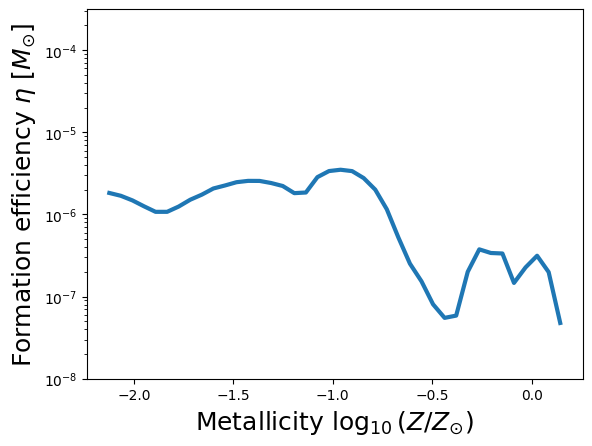

In [9]:
fs=18

hist, bin_edges = np.histogram(np.log10(metallicity_BBHs/0.0142), weights=formation_efficiencies, bins=40, density=True)

bin_centers = (bin_edges[0:-1] + bin_edges[1:])/2
normalization = np.sum(formation_efficiencies)

plt.plot(bin_centers, hist*normalization, lw=3)


plt.yscale('log')
plt.ylim(10**-8, 10**-3.5)

plt.ylabel(r'Formation efficiency $\eta \ [M_{\odot}]$', fontsize=fs)
plt.xlabel(r'Metallicity $\log_{10}(Z/Z_{\odot})$', fontsize=fs)
plt.show()

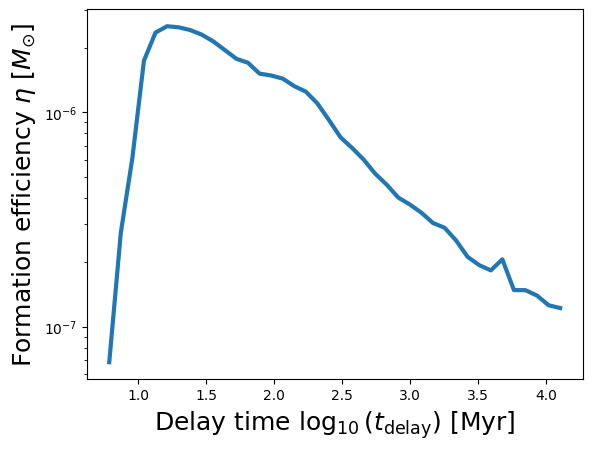

In [10]:
fs=18

hist, bin_edges = np.histogram(np.log10(delay_times), weights=formation_efficiencies, bins=40, density=True)

bin_centers = (bin_edges[0:-1] + bin_edges[1:])/2
normalization = np.sum(formation_efficiencies)

plt.plot(bin_centers, hist*normalization, lw=3)


plt.yscale('log')
# plt.ylim(10**-8, 10**-3.5)

plt.ylabel(r'Formation efficiency $\eta \ [M_{\odot}]$', fontsize=fs)
plt.xlabel(r'Delay time $\log_{10}(t_{\rm{delay}}) \ [\rm{Myr}]$', fontsize=fs)
plt.show()

In [11]:
import os, copy, h5py
import astropy.units as u
import numpy as np
import pandas as pd

import sys

# sys.path.append('/Users/floorbroekgaarden/Projects/GitHub/syntheticstellarpopconvolve')
sys.path.insert(0, '/Users/floorbroekgaarden/Projects/GitHub/syntheticstellarpopconvolve')


In [12]:
# import syntheticstellarpopconvolve 

In [13]:
from syntheticstellarpopconvolve import convolve, default_convolution_config, default_convolution_instruction
from syntheticstellarpopconvolve.general_functions import generate_boilerplate_outputfile, extract_unit_dict, temp_dir

In [44]:
res_lb=0.1
lb_bins_temp = np.arange(0,10+res_lb, step=res_lb)
lb_bins = np.round(lb_bins_temp, 2).tolist()
print(lb_bins)
print(lb_bins*u.Gyr)
print('\n \n \n')

import numpy as np
from astropy import units as u
from astropy.cosmology import Planck18, z_at_value

def redshift_from_lookbacktime(cosmology, lookback_times_gyr):
    """
    Convert one or more lookback times to redshift(s).
    """
    lookback_times = np.atleast_1d(lookback_times_gyr) * u.Gyr
    zs = [z_at_value(cosmology.lookback_time, t) for t in lookback_times]
    return np.array(zs)

# Example
# lbs_z = (np.asarray(lb_bins)+(res_lb/2))
# redshifts = redshift_from_lookbacktime(Planck18, lbs_z)

def lookbacktime_from_redshift(cosmology, redshifts):
    """
    Calculate lookback time(s) from redshift(s).

    Parameters
    ----------
    cosmology : astropy.cosmology.FLRW
        Cosmology instance (e.g., Planck18).
    redshifts : float or array-like
        Redshift(s).

    Returns
    -------
    lookback_times_gyr : float or np.ndarray
        Lookback time(s) in Gyr.
    """
    z = np.atleast_1d(redshifts)
    lb_times = cosmology.lookback_time(z)
    return lb_times.to(u.Gyr).value if np.ndim(redshifts) > 0 else lb_times.to(u.Gyr).value.item()


res_z = 0.2
redshifts = np.arange(0,10+res_z, step=res_z)
# redshifts = np.round(redshifts_temp, 2).tolist()
print(redshifts)
# print(lb_bins*u.Gyr)
print('\n \n \n')


# Examples
lb_bins = lookbacktime_from_redshift(Planck18, redshifts)        # scalar z
# print(lookbacktime_from_redshift(Planck18, [0.5, 1, 3]))  # array of z

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.0, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7.0, 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8.0, 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9.0, 9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10.0]
[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7
  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1
  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5
  5.6  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9
  7.   7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3
  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  

In [28]:
# print(lb_bins)

# print()
print(lb_bins)

[ 0.          2.51207159  4.416738    5.88270245  7.02778637  7.935542
  8.66561385  9.26088035  9.75245879 10.16319076 10.51005492 10.80583627
 11.06028624 11.2809352  11.47366726 11.64313146 11.79303943 11.92638323
 12.04559675 12.15267657 12.2492734  12.33676197 12.416295   12.48884523
 12.55523837 12.61617926 12.67227271 12.72404023 12.77193359 12.81634584
 12.85762035 12.89605826 12.93192463 12.96545356 12.99685251 13.0263059
 13.05397815 13.08001627 13.10455205 13.12770393 13.14957865 13.17027259
 13.189873   13.208459   13.22610252 13.24286908 13.25881846 13.27400528
 13.28847959 13.30228728 13.31547052]


In [30]:
# TMP_DIR = temp_dir(
#     "examples", "minimal_working_example", clean_path=True
# )

# res_lb=0.1
# lb_bins_temp = np.arange(0,10+res_lb, step=res_lb)
# lb_bins = np.round(lb_bins_temp, 2).tolist()
# print(lb_bins)

TMP_DIR = '/Users/floorbroekgaarden/Projects/GitHub/syntheticstellarpopconvolve/temp_dir_try'

# Create instance of output
output_hdf5_filename = os.path.join(TMP_DIR, "output_example.h5")
generate_boilerplate_outputfile(output_hdf5_filename)

# SET UP DATA
example_data = {
    "delay_time": delay_times,
    "ones": np.ones_like(delay_times),
    "probability": formation_efficiencies,
}
example_df = pd.DataFrame.from_records(example_data)
example_df.to_hdf(output_hdf5_filename, key="input_data/example")

# Set up global configuration
convolution_config = copy.copy(default_convolution_config)
convolution_config["output_filename"] = output_hdf5_filename

# Set up SFR
convolution_config["SFR_info"] = {
    "lookback_time_bin_edges": np.asarray(lb_bins) * u.Gyr,
    "starformation_rate_array": np.asarray(lb_bins)[1:] * u.Msun / u.Gyr
}

# set up convolution bin edges
convolution_config["convolution_lookback_time_bin_edges"] = (
    np.asarray(lb_bins) * u.Gyr
)

# print(lb_bins* u.Gyr)

# Set up the convolution instructions
convolution_config["convolution_instructions"] = [
    {
        **default_convolution_instruction,
        "input_data_name": "example",
        "output_data_name": "example",
        "data_column_dict": {
            "delay_time": "delay_time",
            "normalized_yield": {"column_name": "probability", "unit": 1/u.Msun},
        },
    }
]

# run convolution
convolve(convolution_config)

# # read out results
# with h5py.File(
#     convolution_config["output_filename"], "r"
# ) as output_hdf5file:
#     groupname = "output_data/example/example/convolution_results/0.5 Gyr/"

#     yield_data = output_hdf5file[groupname + "/yield"][()]
#     unit_dict = extract_unit_dict(output_hdf5file, groupname)

#     print(yield_data) # values
#     print(unit_dict) # units

In [31]:
fdata.close()

In [33]:
print(np.asarray(lb_bins) * u.Gyr)

[ 0.          2.51207159  4.416738    5.88270245  7.02778637  7.935542
  8.66561385  9.26088035  9.75245879 10.16319076 10.51005492 10.80583627
 11.06028624 11.2809352  11.47366726 11.64313146 11.79303943 11.92638323
 12.04559675 12.15267657 12.2492734  12.33676197 12.416295   12.48884523
 12.55523837 12.61617926 12.67227271 12.72404023 12.77193359 12.81634584
 12.85762035 12.89605826 12.93192463 12.96545356 12.99685251 13.0263059
 13.05397815 13.08001627 13.10455205 13.12770393 13.14957865 13.17027259
 13.189873   13.208459   13.22610252 13.24286908 13.25881846 13.27400528
 13.28847959 13.30228728 13.31547052] Gyr


In [32]:
full_path_sspc = '/Users/floorbroekgaarden/Projects/GitHub/syntheticstellarpopconvolve/temp_dir_try/output_example.h5'
fdata = h5.File(full_path_sspc, 'r')
print(fdata.keys())
print('\n \n')
print(fdata['output_data']['example']['example']['convolution_results'].keys())




<KeysViewHDF5 ['config', 'input_data', 'output_data']>

 

<KeysViewHDF5 ['1.256 Gyr', '10.3366 Gyr', '10.6579 Gyr', '10.9331 Gyr', '11.1706 Gyr', '11.3773 Gyr', '11.5584 Gyr', '11.7181 Gyr', '11.8597 Gyr', '11.986 Gyr', '12.0991 Gyr', '12.201 Gyr', '12.293 Gyr', '12.3765 Gyr', '12.4526 Gyr', '12.522 Gyr', '12.5857 Gyr', '12.6442 Gyr', '12.6982 Gyr', '12.748 Gyr', '12.7941 Gyr', '12.837 Gyr', '12.8768 Gyr', '12.914 Gyr', '12.9487 Gyr', '12.9812 Gyr', '13.0116 Gyr', '13.0401 Gyr', '13.067 Gyr', '13.0923 Gyr', '13.1161 Gyr', '13.1386 Gyr', '13.1599 Gyr', '13.1801 Gyr', '13.1992 Gyr', '13.2173 Gyr', '13.2345 Gyr', '13.2508 Gyr', '13.2664 Gyr', '13.2812 Gyr', '13.2954 Gyr', '13.3089 Gyr', '3.4644 Gyr', '5.1497 Gyr', '6.4552 Gyr', '7.4817 Gyr', '8.3006 Gyr', '8.9632 Gyr', '9.5067 Gyr', '9.9578 Gyr']>


In [19]:
print(redshifts)
print(lb_bins)
diff = np.diff(lb_bins)

print(lb_bins+(diff[0]/2))

[ 0.   0.2  0.4  0.6  0.8  1.   1.2  1.4  1.6  1.8  2.   2.2  2.4  2.6
  2.8  3.   3.2  3.4  3.6  3.8  4.   4.2  4.4  4.6  4.8  5.   5.2  5.4
  5.6  5.8  6.   6.2  6.4  6.6  6.8  7.   7.2  7.4  7.6  7.8  8.   8.2
  8.4  8.6  8.8  9.   9.2  9.4  9.6  9.8 10. ]
[ 0.          2.51207159  4.416738    5.88270245  7.02778637  7.935542
  8.66561385  9.26088035  9.75245879 10.16319076 10.51005492 10.80583627
 11.06028624 11.2809352  11.47366726 11.64313146 11.79303943 11.92638323
 12.04559675 12.15267657 12.2492734  12.33676197 12.416295   12.48884523
 12.55523837 12.61617926 12.67227271 12.72404023 12.77193359 12.81634584
 12.85762035 12.89605826 12.93192463 12.96545356 12.99685251 13.0263059
 13.05397815 13.08001627 13.10455205 13.12770393 13.14957865 13.17027259
 13.189873   13.208459   13.22610252 13.24286908 13.25881846 13.27400528
 13.28847959 13.30228728 13.31547052]
[ 1.2560358   3.76810739  5.67277379  7.13873825  8.28382216  9.1915778
  9.92164965 10.51691614 11.00849458 11.41922656 

In [26]:

center_lb_bins = np.round(lb_bins+(diff[0]/2),4)
print(center_lb_bins)

'1.256 Gyr'

[ 1.256   3.7681  5.6728  7.1387  8.2838  9.1916  9.9216 10.5169 11.0085
 11.4192 11.7661 12.0619 12.3163 12.537  12.7297 12.8992 13.0491 13.1824
 13.3016 13.4087 13.5053 13.5928 13.6723 13.7449 13.8113 13.8722 13.9283
 13.9801 14.028  14.0724 14.1137 14.1521 14.188  14.2215 14.2529 14.2823
 14.31   14.3361 14.3606 14.3837 14.4056 14.4263 14.4459 14.4645 14.4821
 14.4989 14.5149 14.53   14.5445 14.5583 14.5715]


In [22]:
# from astropy.cosmology import WMAP7   # WMAP 7-year cosmology, change to correct one
# from astropy.cosmology import z_at_value
# cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)


# redshifts = z_at_value(cosmo.age, lb_bins)

# print(redshifts)

In [51]:
lb_values = np.asarray(lb_bins)
print(lb_values)

diff = np.diff(lb_bins) # = lookbacktime_from_redshift(Planck18, redshifts)  
print(diff)
print('\n')


center_lb_bins = lb_values[:-1] + (diff/2)
center_lb_bins_round = np.round(center_lb_bins, 4)
print('\n')
print(center_lb_bins_round)
# center_lb_bins = np.round(np.asarray(lb_bins)[-1]+(diff/2),4)
# print(center_lb_bins)
# print(np.sort(center_lb_bins))


keys_ = ['1.256 Gyr', '10.3366 Gyr', '10.6579 Gyr', '10.9331 Gyr', '11.1706 Gyr', '11.3773 Gyr', '11.5584 Gyr', '11.7181 Gyr', '11.8597 Gyr', '11.986 Gyr', '12.0991 Gyr', '12.201 Gyr', '12.293 Gyr', '12.3765 Gyr', '12.4526 Gyr', '12.522 Gyr', '12.5857 Gyr', '12.6442 Gyr', '12.6982 Gyr', '12.748 Gyr', '12.7941 Gyr', '12.837 Gyr', '12.8768 Gyr', '12.914 Gyr', '12.9487 Gyr', '12.9812 Gyr', '13.0116 Gyr', '13.0401 Gyr', '13.067 Gyr', '13.0923 Gyr', '13.1161 Gyr', '13.1386 Gyr', '13.1599 Gyr', '13.1801 Gyr', '13.1992 Gyr', '13.2173 Gyr', '13.2345 Gyr', '13.2508 Gyr', '13.2664 Gyr', '13.2812 Gyr', '13.2954 Gyr', '13.3089 Gyr', '3.4644 Gyr', '5.1497 Gyr', '6.4552 Gyr', '7.4817 Gyr', '8.3006 Gyr', '8.9632 Gyr', '9.5067 Gyr', '9.9578 Gyr']
print('\n')
print(np.sort(keys_))

[ 0.          2.51207159  4.416738    5.88270245  7.02778637  7.935542
  8.66561385  9.26088035  9.75245879 10.16319076 10.51005492 10.80583627
 11.06028624 11.2809352  11.47366726 11.64313146 11.79303943 11.92638323
 12.04559675 12.15267657 12.2492734  12.33676197 12.416295   12.48884523
 12.55523837 12.61617926 12.67227271 12.72404023 12.77193359 12.81634584
 12.85762035 12.89605826 12.93192463 12.96545356 12.99685251 13.0263059
 13.05397815 13.08001627 13.10455205 13.12770393 13.14957865 13.17027259
 13.189873   13.208459   13.22610252 13.24286908 13.25881846 13.27400528
 13.28847959 13.30228728 13.31547052]
[2.51207159 1.9046664  1.46596446 1.14508391 0.90775564 0.73007185
 0.59526649 0.49157844 0.41073198 0.34686415 0.29578135 0.25444998
 0.22064896 0.19273206 0.16946421 0.14990797 0.13334379 0.11921352
 0.10707982 0.09659683 0.08748857 0.07953304 0.07255023 0.06639314
 0.06094089 0.05609345 0.05176752 0.04789336 0.04441225 0.04127451
 0.03843791 0.03586636 0.03352893 0.03139895 0

In [55]:
lb_values = np.asarray(lb_bins)
diff = np.diff(lb_bins) # = lookbacktime_from_redshift(Planck18, redshifts)  

center_lb_bins = lb_values[:-1] + (diff/2) # take the centers of the bins 
center_lb_bins_round = np.round(center_lb_bins, 4) # round to mathc printing




total_rate = np.zeros_like(redshifts)
for ind_lb, lb_time in enumerate(center_lb_bins_round):
    
    print(ind_lb, lb_time)
#     print(fdata['output_data']['example']['example']['convolution_results']['%s Gyr'%lb_time]['yield'].keys())
    rate = fdata['output_data']['example']['example']['convolution_results']['%s Gyr'%lb_time]['yield'][()]
    total_rate[ind_lb] = np.sum(rate)
    
print(redshifts)
print(total_rate)

0 1.256
1 3.4644
2 5.1497
3 6.4552
4 7.4817
5 8.3006
6 8.9632
7 9.5067
8 9.9578
9 10.3366
10 10.6579
11 10.9331
12 11.1706
13 11.3773
14 11.5584
15 11.7181
16 11.8597
17 11.986
18 12.0991
19 12.201
20 12.293
21 12.3765
22 12.4526
23 12.522
24 12.5857
25 12.6442
26 12.6982
27 12.748
28 12.7941
29 12.837
30 12.8768
31 12.914
32 12.9487
33 12.9812
34 13.0116
35 13.0401
36 13.067
37 13.0923
38 13.1161
39 13.1386
40 13.1599
41 13.1801
42 13.1992
43 13.2173
44 13.2345
45 13.2508
46 13.2664
47 13.2812
48 13.2954
49 13.3089
[ 0.   0.2  0.4  0.6  0.8  1.   1.2  1.4  1.6  1.8  2.   2.2  2.4  2.6
  2.8  3.   3.2  3.4  3.6  3.8  4.   4.2  4.4  4.6  4.8  5.   5.2  5.4
  5.6  5.8  6.   6.2  6.4  6.6  6.8  7.   7.2  7.4  7.6  7.8  8.   8.2
  8.4  8.6  8.8  9.   9.2  9.4  9.6  9.8 10. ]
[8.09855641e-06 1.42389261e-05 1.89649840e-05 2.26565694e-05
 2.55830426e-05 2.79366889e-05 2.98557422e-05 3.14405202e-05
 3.27646608e-05 3.38829008e-05 3.48364572e-05 3.56567672e-05
 3.63681076e-05 3.69894480e-05 3.75

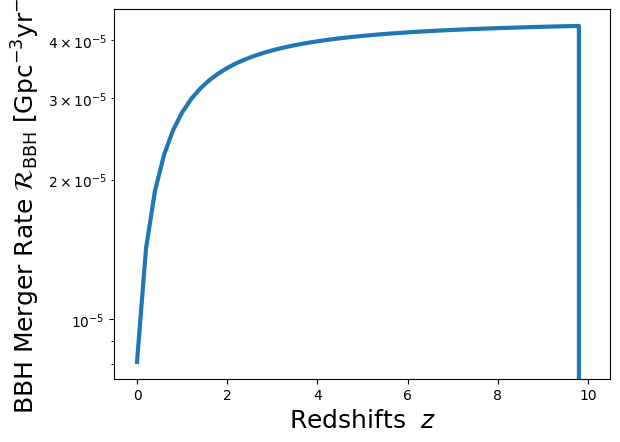

In [54]:
fs=18


plt.plot(redshifts, total_rate, lw=3)


plt.yscale('log')
# plt.ylim(10**-8, 10**-3.5)

plt.ylabel(r'BBH Merger Rate $\mathcal{R}_{\rm{BBH}} \ [\rm{Gpc}^{-3} \rm{yr}^{-1}]$', fontsize=fs)
plt.xlabel(r'Redshifts  $z$', fontsize=fs)
plt.show()



In [25]:
print(fdata['output_data']['example']['example']['convolution_results'].keys())
# print(np.shape(yield_))
# print(np.sum(yield_))


<KeysViewHDF5 ['1.256 Gyr', '10.3366 Gyr', '10.6579 Gyr', '10.9331 Gyr', '11.1706 Gyr', '11.3773 Gyr', '11.5584 Gyr', '11.7181 Gyr', '11.8597 Gyr', '11.986 Gyr', '12.0991 Gyr', '12.201 Gyr', '12.293 Gyr', '12.3765 Gyr', '12.4526 Gyr', '12.522 Gyr', '12.5857 Gyr', '12.6442 Gyr', '12.6982 Gyr', '12.748 Gyr', '12.7941 Gyr', '12.837 Gyr', '12.8768 Gyr', '12.914 Gyr', '12.9487 Gyr', '12.9812 Gyr', '13.0116 Gyr', '13.0401 Gyr', '13.067 Gyr', '13.0923 Gyr', '13.1161 Gyr', '13.1386 Gyr', '13.1599 Gyr', '13.1801 Gyr', '13.1992 Gyr', '13.2173 Gyr', '13.2345 Gyr', '13.2508 Gyr', '13.2664 Gyr', '13.2812 Gyr', '13.2954 Gyr', '13.3089 Gyr', '3.4644 Gyr', '5.1497 Gyr', '6.4552 Gyr', '7.4817 Gyr', '8.3006 Gyr', '8.9632 Gyr', '9.5067 Gyr', '9.9578 Gyr']>


In [ ]:
3.768

In [37]:
print(lb_bins)

print(np.diff(lb_bins))
diff = 4.416738-2.51207159  
print(2.51207159  +diff/2)

[ 0.          2.51207159  4.416738    5.88270245  7.02778637  7.935542
  8.66561385  9.26088035  9.75245879 10.16319076 10.51005492 10.80583627
 11.06028624 11.2809352  11.47366726 11.64313146 11.79303943 11.92638323
 12.04559675 12.15267657 12.2492734  12.33676197 12.416295   12.48884523
 12.55523837 12.61617926 12.67227271 12.72404023 12.77193359 12.81634584
 12.85762035 12.89605826 12.93192463 12.96545356 12.99685251 13.0263059
 13.05397815 13.08001627 13.10455205 13.12770393 13.14957865 13.17027259
 13.189873   13.208459   13.22610252 13.24286908 13.25881846 13.27400528
 13.28847959 13.30228728 13.31547052]
[2.51207159 1.9046664  1.46596446 1.14508391 0.90775564 0.73007185
 0.59526649 0.49157844 0.41073198 0.34686415 0.29578135 0.25444998
 0.22064896 0.19273206 0.16946421 0.14990797 0.13334379 0.11921352
 0.10707982 0.09659683 0.08748857 0.07953304 0.07255023 0.06639314
 0.06094089 0.05609345 0.05176752 0.04789336 0.04441225 0.04127451
 0.03843791 0.03586636 0.03352893 0.03139895 0

In [ ]:
print(fdata.close())

In [ ]:
print(fdata['output_data']['example']['example']['convolution_results'].keys())

In [ ]:
res_lb=0.1
lb_bins = np.arange(0,10+res_lb, step=res_lb)
# print(lb_bins)




In [ ]:
fdata.close()

## Try again but now based on redshift & updated plots 
(I think SFR is missing), below is based on https://synthetic-stellar-pop-convolve.readthedocs.io/en/latest/examples/notebook_example_GW_merger_rate_density.html 

In [57]:
import os
import json
import pkg_resources
import copy
import logging
import h5py

import pandas as pd
import numpy as np
import astropy.units as u

from syntheticstellarpopconvolve import convolve, default_convolution_config, default_convolution_instruction
from syntheticstellarpopconvolve.general_functions import temp_dir, generate_boilerplate_outputfile

TMP_DIR = '/Users/floorbroekgaarden/Projects/GitHub/syntheticstellarpopconvolve/temp_dir_try' # #temp_dir("notebooks", "notebook_example_GW_merger_rate_density", clean_path=True)
VERBOSITY = 0

# The flag below allows the user to run this notebook without the full data or starformation rate.
FULL_VERSION = os.getenv("EXAMPLE_USECASE_GW_FULL_VERSION", False)

import matplotlib as plt

from syntheticstellarpopconvolve.starformation_rate_distributions import starformation_rate_distribution_vanSon2023
from syntheticstellarpopconvolve.metallicity_distributions import metallicity_distribution_vanSon2022
from syntheticstellarpopconvolve.general_functions import calculate_bincenters, calculate_bin_edges
from syntheticstellarpopconvolve.SFR_dict_plotting_routines import plot_sfr_dict

### Set up SFR(Z,z)

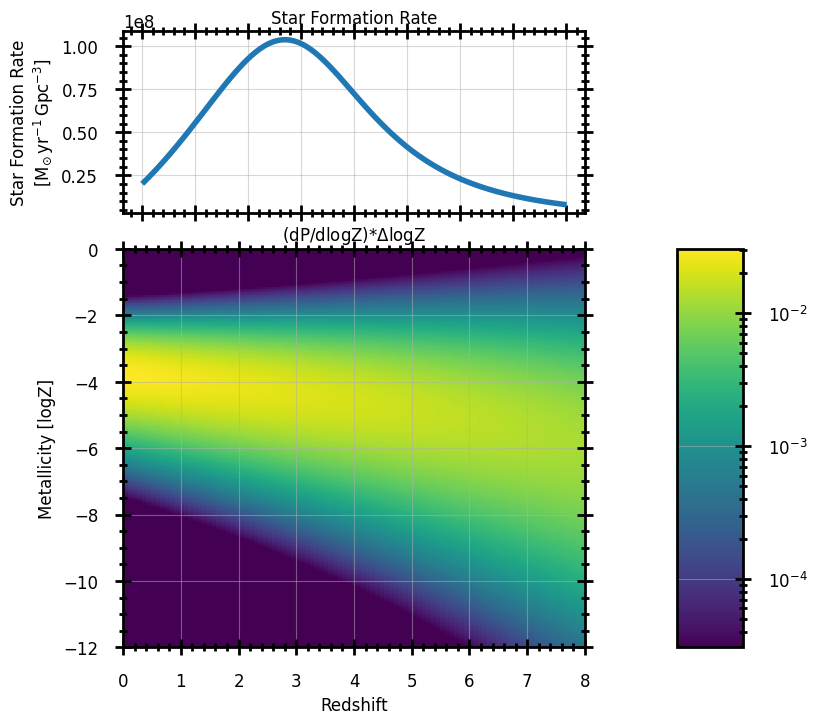

In [58]:


# Set up redshift bin info
num_redshift_bins = 100
redshift_bin_edges = np.linspace(0, 8, num_redshift_bins); redshift_bin_centers = calculate_bincenters(redshift_bin_edges)

# Set up metallicity bin info
num_metallicity_bins = 200
log_metallicity_bin_edges = np.linspace(-12, 0, num_metallicity_bins); log_metallicity_bin_centers = calculate_bincenters(log_metallicity_bin_edges)

#
sfr = starformation_rate_distribution_vanSon2023(redshift_bin_centers).to(u.Msun/u.yr/u.Gpc**3)

#
dpdlogZ = metallicity_distribution_vanSon2022(
    log_metallicity_centers=log_metallicity_bin_centers,
    redshifts=redshift_bin_centers,
)

high_res_sfr_dict = {
    "redshift_bin_edges": redshift_bin_edges,
    "starformation_rate_array": sfr,
    "metallicity_bin_edges": log_metallicity_bin_edges,
    "metallicity_distribution_array": dpdlogZ,
}

axis_dict = plot_sfr_dict(
    high_res_sfr_dict,
    time_type="redshift",
    metallicity_string="logZ",
    metallicity_distribution_multiply_by_metallicity_bin_sizes=True,
    metallicity_distribution_multiply_by_sfr=False,
    metallicity_distribution_scale="log10",
    metallicity_distribution_cmap=copy.copy(plt.cm.viridis),
    return_axis_dict=True,
    figsize=(8,8),
    fontsize=12,
)

In [71]:
# metallicity data from earlier (from COMPAS simulations)

# hist, bin_edgeshist, bin_edges = np.histogram(np.log10(metallicity_BBHs/0.0142), weights=formation_efficiencies, bins=40, density=True)

# bin_centers = (bin_edges[0:-1] + bin_edges[1:])/2
bin_centers = (bin_edges[0:-1] + bin_edges[1:])/2

print(bin_edges)
print(bin_centers)

temp_bin_centers =  (10**bin_centers)*0.0142
print(temp_bin_centers)



_, bin_edgeshist_sspc = np.histogram(np.log(metallicity_BBHs), weights=formation_efficiencies, bins=40, density=True)
bin_centers_sspc = (bin_edgeshist_sspc[0:-1] + bin_edgeshist_sspc[1:])/2

print()
print(bin_edgeshist_sspc)
print(calculate_bin_edges(bin_centers_sspc))

[0.74407147 0.82914423 0.91421699 0.99928975 1.08436251 1.16943527
 1.25450803 1.33958079 1.42465355 1.50972631 1.59479907 1.67987183
 1.76494458 1.85001734 1.9350901  2.02016286 2.10523562 2.19030838
 2.27538114 2.3604539  2.44552666 2.53059942 2.61567218 2.70074494
 2.7858177  2.87089046 2.95596322 3.04103598 3.12610874 3.2111815
 3.29625426 3.38132702 3.46639978 3.55147254 3.6365453  3.72161806
 3.80669082 3.89176358 3.97683634 4.0619091  4.14698186]
[0.78660785 0.87168061 0.95675337 1.04182613 1.12689889 1.21197165
 1.29704441 1.38211717 1.46718993 1.55226269 1.63733545 1.7224082
 1.80748096 1.89255372 1.97762648 2.06269924 2.147772   2.23284476
 2.31791752 2.40299028 2.48806304 2.5731358  2.65820856 2.74328132
 2.82835408 2.91342684 2.9984996  3.08357236 3.16864512 3.25371788
 3.33879064 3.4238634  3.50893616 3.59400892 3.67908168 3.76415444
 3.8492272  3.93429996 4.01937272 4.10444548]
[8.68752746e-02 1.05674195e-01 1.28541011e-01 1.56355971e-01
 1.90189804e-01 2.31344932e-01 2.8

(1e-06, 1)

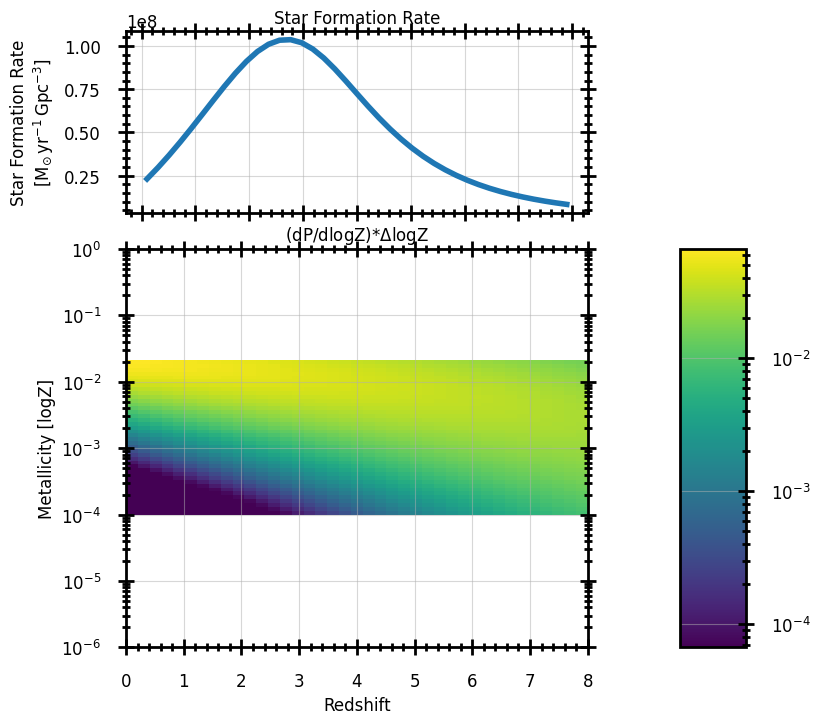

In [72]:
# example_usecase_GW_events_data['log_metallicity'] = np.log(example_usecase_GW_events_data['metallicity'])

# log_metallicity_bin_centers = np.sort(example_usecase_GW_events_data['log_metallicity'].unique())
# log_metallicity_bin_edges = calculate_bin_edges(log_metallicity_bin_centers)


log_metallicity_bin_centers = np.asarray(bin_centers_sspc)
log_metallicity_bin_edges = np.asarray(bin_edgeshist_sspc)

# convert
metallicity_bin_centers = np.exp(log_metallicity_bin_centers)
metallicity_bin_edges = np.exp(log_metallicity_bin_edges)

# Set up redshift bin info
num_redshift_bins = 40
redshift_bin_edges = np.linspace(0, 8, num_redshift_bins); redshift_bin_centers = calculate_bincenters(redshift_bin_edges)

#
dpdlogZ = metallicity_distribution_vanSon2022(
    log_metallicity_centers=log_metallicity_bin_centers,
    redshifts=redshift_bin_centers,
)

#
sfr = starformation_rate_distribution_vanSon2023(redshift_bin_centers).to(u.Msun/u.yr/u.Gpc**3)

#
sfr_dict = {
    "redshift_bin_edges": redshift_bin_edges,
    "starformation_rate_array": sfr,
    "metallicity_bin_edges": metallicity_bin_edges,
    "metallicity_distribution_array": ((1/metallicity_bin_centers) * dpdlogZ),  # We need to transpose!
}

axis_dict = plot_sfr_dict(
    sfr_dict,
    time_type="redshift",
    metallicity_string="logZ",
    metallicity_distribution_multiply_by_metallicity_bin_sizes=True,
    metallicity_distribution_multiply_by_sfr=False,
    metallicity_distribution_scale="log10",
    metallicity_distribution_cmap=copy.copy(plt.cm.viridis),
    return_axis_dict=True,
    figsize=(8,8),
    fontsize=12,
)
axis_dict['ax_mssfr'].set_yscale('log')
axis_dict['ax_mssfr'].set_ylim([0.000001, 1])

In [ ]:
# Assign filenames
output_hdf5_filename = os.path.join(TMP_DIR, "output_hdf5.h5")
generate_boilerplate_outputfile(output_hdf5_filename)

# store the data frame in the hdf5file
example_usecase_GW_events_data.to_hdf(output_hdf5_filename, key="input_data/example_GW_merger_rate_density")

print(example_usecase_GW_events_data.columns)

# Some general configuration
convolution_config = copy.copy(default_convolution_config)
convolution_config['logger'].setLevel(logging.WARNING)
convolution_config["output_filename"] = output_hdf5_filename
convolution_config["tmp_dir"] = TMP_DIR
convolution_config["redshift_interpolator_data_output_filename"] = os.path.join(
    TMP_DIR, "interpolator_dict.p"
)
convolution_config["multiply_by_time_binsize"] = False
convolution_config["time_type"] = "redshift"

# convolution instructions
convolution_config["convolution_instructions"] = [
    {
        **default_convolution_instruction,
        "convolution_type": "integrate",
        "input_data_name": "example_GW_merger_rate_density",
        "output_data_name": "intrinsic",
        "data_column_dict": {
            # required
            "normalized_yield": "number_per_solar_mass_values",
            "delay_time": {"column_name": "delay_time_values_in_years", "unit": u.yr},
            "metallicity": "metallicity"
        },
    },
]

# configure the target convolution times. In this case we only want to model the rate at redshift ~0, so its a simple set up
convolution_config["convolution_redshift_bin_edges"] = np.array([0, 0.25])

# store
convolution_config["SFR_info"] = sfr_dict